# Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

# Image Processing

In [3]:
# Load and preprocess image
def load_and_preprocess_image(file_path, img_size=(128, 128)):
    image = Image.open(file_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])
    return transform(image)

# Create Batch of Watermarks

In [4]:
# Create a batch of random watermarks, each of shape (1, img_size[0], img_size[1])

def create_random_watermark(batch_size, img_size=(128, 128)):

    return torch.rand(batch_size, 1, img_size[0], img_size[1])

# Create Function for Image Display

In [5]:
# Display images

def display_images(original, watermarked, extracted):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original.permute(1, 2, 0).cpu())
    axs[0].set_title("Original Image")
    axs[1].imshow(watermarked.permute(1, 2, 0).cpu())
    axs[1].set_title("Watermarked Image")
    axs[2].imshow(extracted.squeeze(0).cpu(), cmap="gray")
    axs[2].set_title("Extracted Watermark")
    plt.show()

# Create Encoder Network

In [6]:
# Encoder Network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, image, watermark):
        x = torch.cat([image, watermark], dim=1)  # Concatenate along channel axis
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return torch.sigmoid(self.conv3(x))  # Output watermarked image



# Create Decoder Network

In [7]:
# Decoder Network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, watermarked_image):
        x = torch.relu(self.conv1(watermarked_image))
        x = torch.relu(self.conv2(x))
        return torch.sigmoid(self.conv3(x))  # Output recovered watermark

# Initialize Models, Loss Function and Optimizer

In [8]:
# Initialize models, loss function, and optimizer
encoder = Encoder()
decoder = Decoder()
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)



# Create Training Loop Function

In [ ]:
# Training loop
def train_step(images, watermarks, encoder, decoder, optimizer):
    encoder.train()
    decoder.train()

    # Forward pass through encoder
    watermarked_images = encoder(images, watermarks)

    # Forward pass through decoder
    recovered_watermarks = decoder(watermarked_images)

    # Loss calculation
    image_loss = mse_loss(watermarked_images, images)
    watermark_loss = bce_loss(recovered_watermarks, watermarks)
    loss = image_loss + watermark_loss

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# Import Dataset for Training and Test

In [9]:
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset


# CIFAR-10 transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a larger size if needed
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
cifar10_full = CIFAR10(root="./data", train=True, transform=transform, download=True)

# Use only 1% of the dataset
subset_size = int(0.001 * len(cifar10_full))
subset_indices = np.random.choice(len(cifar10_full), subset_size, replace=False)  # Randomly select 1%
cifar10_subset = Subset(cifar10_full, subset_indices)

# Create DataLoader for the subset
dataloader = DataLoader(cifar10_subset, batch_size=8, shuffle=True)

100%|██████████| 170M/170M [00:02<00:00, 70.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Train Model

In [10]:
# Define the number of epochs
epochs = 10



# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)
decoder = decoder.to(device)



# Training loop with gradient clipping
for epoch in range(epochs):
    for batch in dataloader:
        images, _ = batch
        images = images.to(device)
        watermarks = create_random_watermark(batch_size=images.size(0)).to(device)

        optimizer.zero_grad()
        loss = train_step(images, watermarks, encoder, decoder, optimizer)

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

Epoch 1/10, Loss: 0.7961
Epoch 2/10, Loss: 0.7470
Epoch 3/10, Loss: 0.7335
Epoch 4/10, Loss: 0.7295
Epoch 5/10, Loss: 0.7225
Epoch 6/10, Loss: 0.7017
Epoch 7/10, Loss: 0.6984
Epoch 8/10, Loss: 0.6944
Epoch 9/10, Loss: 0.6964
Epoch 10/10, Loss: 0.7011


# Inference: Testing Model with Dataset

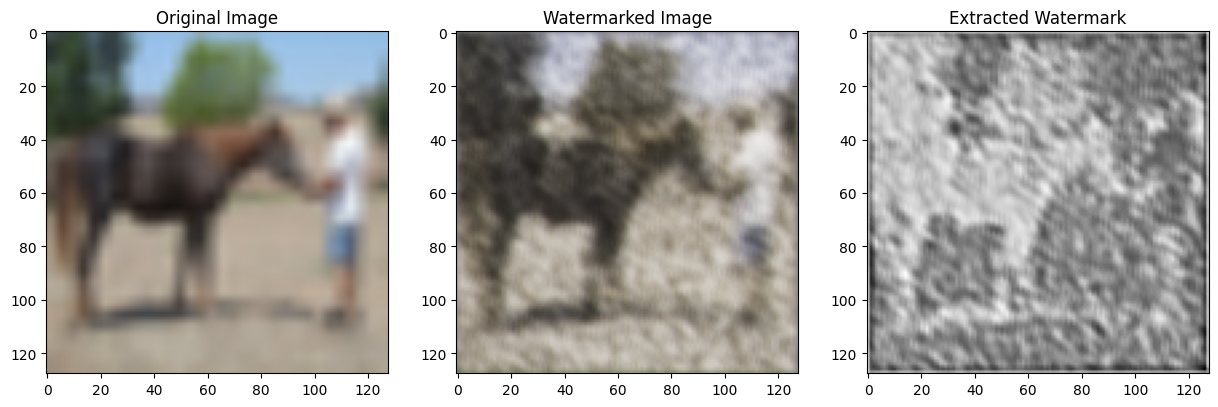

In [18]:
# Test the model with CIFAR-10 data
encoder.eval()
decoder.eval()

with torch.no_grad():
    for batch in dataloader:
        images, _ = batch
        images = images.to(device)

        # Create watermarks
        watermarks = torch.rand(images.size(0), 1, 128, 128).to(device)

        # Generate watermarked image
        watermarked_image = encoder(images, watermarks)

        # Extract watermark from watermarked image
        extracted_watermark = decoder(watermarked_image)

        # Display results
        display_images(images[0], watermarked_image[0], extracted_watermark[0])
        break  # Display only one batch